In [12]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [14]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
os.listdir('/content/gdrive/My Drive/vc_modeling/data')

Mounted at /content/gdrive


['crunchbase_bulk_export',
 'valuation_predictor.ipynb',
 'timeline.csv',
 'investor_df.csv',
 'success_pct_by_category.csv',
 'organization_founders_features.csv',
 'organization_success.csv']

In [15]:
path_prefix = "/content/gdrive/My Drive/vc_modeling/data/"
feature_csv_filenames = ["organization_founders_features.csv", "organization_success.csv"]
dfs = [pd.read_csv(path_prefix + x) for x in feature_csv_filenames]
df_names = [x[:-4] for x in feature_csv_filenames]
df_dict = dict(zip(df_names, dfs))
df_dict.keys()

dict_keys(['organization_founders_features', 'organization_success'])

In [16]:
founders_df = df_dict["organization_founders_features"]
founders_df.head()

,org_uuid,founders_top_rank,founders_top_college,founders_max_degree_type_ordinal,founders_max_degree_count,founders_count
0,000014da-0c46-b9cb-0941-3a93c027b119,265041.0,0.0,2.0,1.0,4
1,00002470-bff7-6226-5800-0ca1b3787b6f,6551.0,1.0,2.0,2.0,2
2,00007c5c-9260-0dfb-c160-89a416f1a7cc,180759.0,NaN,NaN,NaN,2
3,0000b5c1-07dd-aeb6-2b17-eb3d64e652a6,147007.0,0.0,2.0,1.0,1
4,0000c0e1-eb00-9281-9a7f-63dfa277e8df,289919.0,NaN,NaN,NaN,1


In [ ]:
timeline_df = df_dict["timeline"]
timeline_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470732 entries, 0 to 470731
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   org_uuid       470732 non-null  object 
 1   date           470732 non-null  object 
 2   valuation      36215 non-null   float64
 3   event          470713 non-null  object 
 4   is_succeeding  470732 non-null  bool   
 5   has_succeeded  470732 non-null  bool   
dtypes: bool(2), float64(1), object(3)
memory usage: 15.3+ MB


In [17]:
org_success = df_dict["organization_success"]
org_success.head()

,uuid,has_succeeded
0,e1393508-30ea-8a36-3f96-dd3226033abd,1
1,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,1
2,4111dc8b-c0df-2d24-ed33-30cd137b3098,1
3,180ebf67-68d0-2316-e93d-8e1e546330ba,1
4,ea091a8c-40e0-0607-e05a-86e734f94ade,1


In [52]:
#timeline_df["has_succeeded"] = timeline_df["has_succeeded"].astype(int)
#timeline_success_df = timeline_df[timeline_df["has_succeeded"] == 1].drop_duplicates(["org_uuid"])[["org_uuid", "has_succeeded"]]
#print("num companies succeeded: " + str(len(timeline_success_df)))

founders_and_success_df = founders_df.join(org_success.set_index("uuid"), on=["org_uuid"])
founders_and_success_df = founders_and_success_df.dropna(subset=["has_succeeded"])

cols = list(founders_and_success_df.columns)
cols.remove('org_uuid')
founders_and_success_df = founders_and_success_df.dropna(how="all", subset=cols)
founders_and_success_df[:50]

,org_uuid,founders_top_rank,founders_top_college,founders_max_degree_type_ordinal,founders_max_degree_count,founders_count,has_succeeded
11,0002da99-6654-1ecd-79c6-8064a01ebfa6,351505.0,NaN,NaN,NaN,3,1.0
15,0004c2e0-9717-45af-8496-2a899f1276f0,239707.0,NaN,NaN,NaN,1,0.0
17,000607fc-cea0-535c-6324-e83ba07c8cc7,273802.0,1.0,NaN,1.0,1,1.0
19,000644d4-9e1b-3c90-4793-36d656d58f22,272821.0,NaN,NaN,NaN,1,1.0
20,00072c6c-1d18-61b3-46b2-c647efcc3dd5,126724.0,1.0,2.0,2.0,2,0.0
21,00075144-ce2b-4636-8c36-462c6a12452e,333092.0,NaN,NaN,NaN,1,0.0
22,0007585e-f95d-32d2-762f-b20740851cec,443508.0,NaN,NaN,NaN,1,0.0
23,0008239e-a285-43a0-bfe2-e6815b7221b7,111728.0,NaN,NaN,NaN,1,0.0
25,00086114-83d0-04c1-2bf8-9d9a838108d8,758367.0,NaN,NaN,NaN,2,0.0
29,000a321e-5e08-d553-b65e-60548f4b76bd,571594.0,0.0,1.0,1.0,2,0.0


In [42]:
len(founders_and_success_df[founders_and_success_df["has_succeeded"]==1])

20080

Testing Logistic Regression model...
      p     n
Y  5549  2233
N   476   647
error: 0.3042111173498035
roc auc: 0.6561763606052645

Testing CART model...
      p     n
Y  5558  2175
N   467   705
error: 0.2966872543514879
roc auc: 0.6558208405141256

Testing Random Forest model...
      p     n
Y  5203  1992
N   822   888
error: 0.31600224592925324
roc auc: 0.6259533841239566



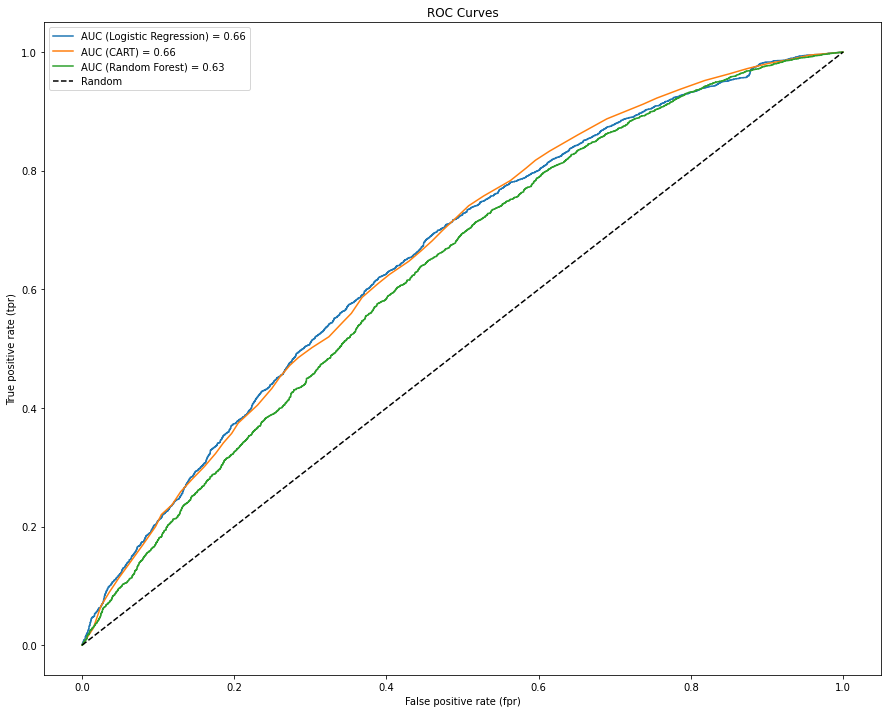

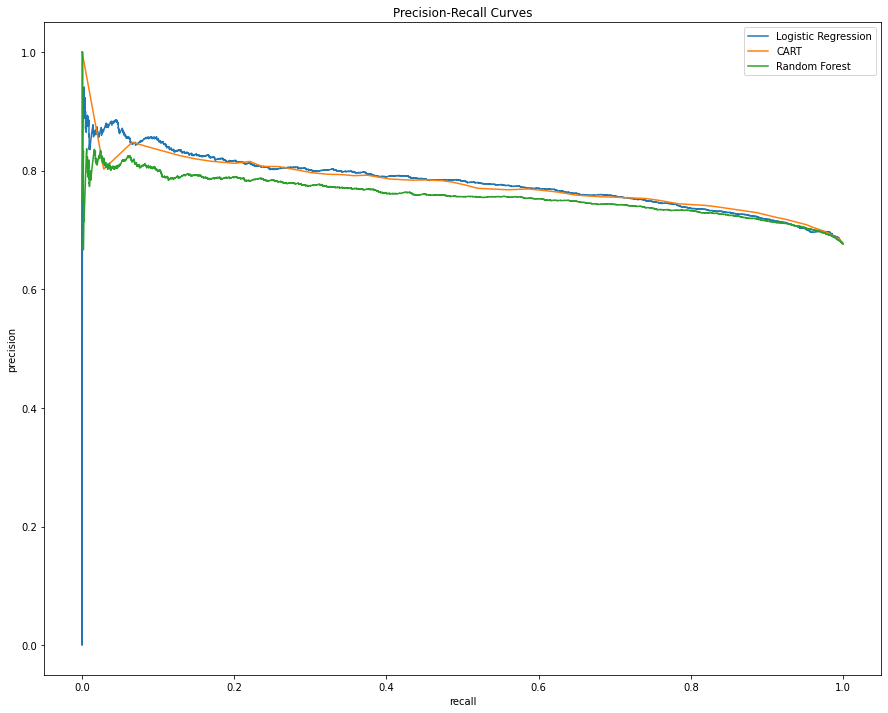

In [53]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 12

imp = SimpleImputer(missing_values=np.nan, strategy='mean')

modelConfigs = [
    {'label': 'Logistic Regression', 'model': LogisticRegression(C=1., solver='liblinear')},
    {'label': 'CART', 'model': DecisionTreeClassifier(criterion="entropy", min_samples_leaf=300, random_state=42)},
    {'label': 'Random Forest', 'model': RandomForestClassifier(max_depth=70, min_samples_leaf=4, min_samples_split=10, n_estimators=400, random_state=42)}
]

data = founders_and_success_df
Y = data['has_succeeded']
X = data.drop(['org_uuid', 'has_succeeded'], axis=1)

# standardize columns
X[:] = StandardScaler().fit_transform(X[:])

# impute missing values
imp = imp.fit(X)
X[:] = imp.transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=422)

modelData = []

for config in modelConfigs:
    print("Testing " + config['label'] + " model...")
    model = config['model']
    X_train_imputed = X_train
    model.fit(X_train_imputed, Y_train)

    # Get the probability of Y_test records being = 1
    X_test_imputed = X_test
    Y_test_probability_1 = model.predict_proba(X_test_imputed)[:, 1]
    
    prediction = Y_test_probability_1 > 0.50

    # Build and print a confusion matrix
    confusion_matrix = metrics.confusion_matrix(Y_test, prediction, labels=[1, 0])
    confusion_matrix_large = pd.DataFrame(confusion_matrix.T, columns=['p', 'n'], index=['Y', 'N'])
    
    # Compute tp, fp, tn and fn to compute error
    tp = confusion_matrix[0][0]
    fp = confusion_matrix[0][1]
    tn = confusion_matrix[1][1]
    fn = confusion_matrix[1][0]
    error = (fp + fn) / (tp + fp + tn + fn)
    print(confusion_matrix_large)
    print("error: " + str(error))

    # Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_test_probability_1)
    
    # Get the area under the curve (AUC)
    auc = np.mean(cross_val_score(model, X, Y, scoring="roc_auc", cv=5))
    print("roc auc: " + str(auc))

    # Calculate precision-recall
    precision, recall, _ = precision_recall_curve(Y_test, Y_test_probability_1)
    # Store model data to plot later
    modelData.append({'config': config, 'fpr': fpr, 'tpr': tpr, 'auc': auc, 'precision': precision, 'recall': recall})
    
    print("")
    
# plot ROC curves
for x in modelData:
    fpr = x['fpr']
    tpr = x['tpr']
    plt.plot(fpr, tpr, label="AUC (" + x['config']['label'] + ") = " + str(round(x['auc'], 2)))

plt.title("ROC Curves")
plt.xlabel("False positive rate (fpr)")
plt.ylabel("True positive rate (tpr)")
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.legend(loc='best')

# plot precision-recall curves
plt.figure()
plt.title("Precision-Recall Curves")
for x in modelData:
    precision = x['precision']
    recall = x['recall']
    plt.plot(recall, precision, label=x['config']['label'])

plt.ylabel("precision")
plt.xlabel("recall")
plt.legend(loc='best')

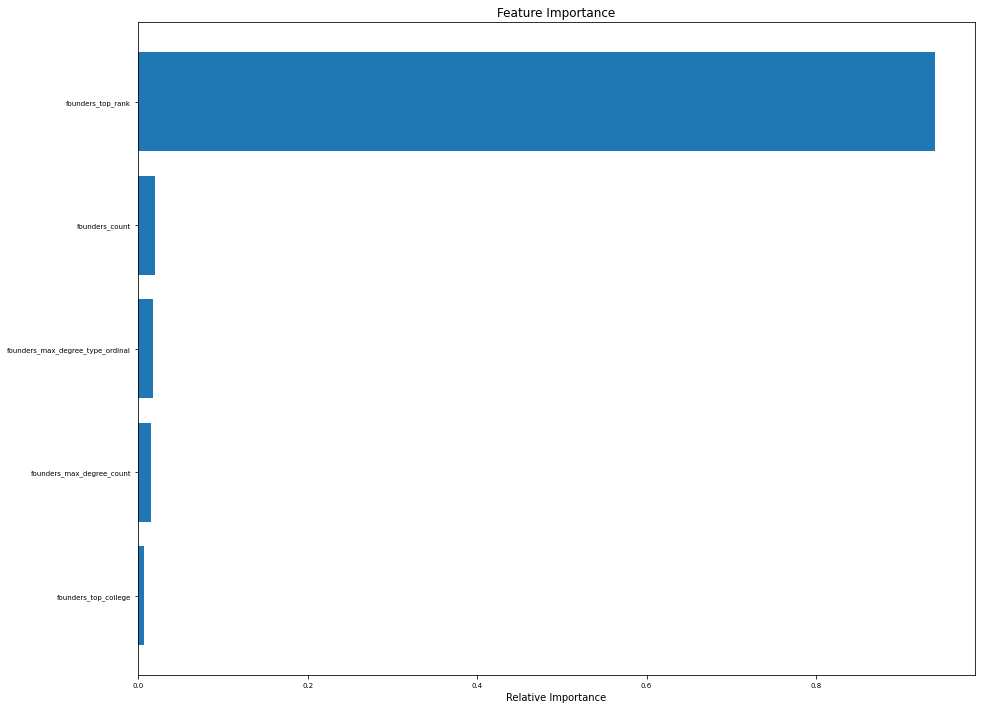

Features ranked by importance (1st is most important): ['founders_top_rank', 'founders_count', 'founders_max_degree_type_ordinal', 'founders_max_degree_count', 'founders_top_college']


In [34]:
# Rank importance of features using Random Forest

clf = RandomForestClassifier()
clf.fit(X, Y)


features = X.columns
importances = clf.feature_importances_
sorted_idx = np.argsort(importances)

padding = np.arange(len(features))
plt.barh(padding, importances[sorted_idx], align='center')
plt.tick_params(labelsize=7)
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Feature Importance")
plt.show()

features_by_importance = [features[idx] for idx in sorted_idx]
features_by_importance.reverse()
print("Features ranked by importance (1st is most important): " + str(features_by_importance))